# Titanic (with pandas)

In [1237]:
# third party
from tabulate import tabulate
import matplotlib.pyplot as plot
import numpy
import pandas
import seaborn

In [1238]:
%matplotlib inline

In [1239]:
seaborn.set_style("whitegrid")
seaborn.set_palette("deep")

# Loading The Data

In [1240]:
TRAINING_DATA = "train.csv"
TESTING_DATA = "test.csv"

In [1241]:
data = pandas.read_csv(TRAINING_DATA)
test_data = pandas.read_csv(TESTING_DATA)

At the end the non-numeric columns and the columns with missing data have to be dropped, so I'm setting it here so it doesn't get mixed up with any columns I add later.

In [1242]:
NUMERIC_TYPES = (numpy.float64, numpy.int64)
NON_NUMERIC = [column for column in data.columns if data[column].dtype not in NUMERIC_TYPES]
HAS_NANS = [column for column in data.columns if data[column].hasnans]

In [1243]:
print(tabulate(data.head(), headers=data.columns.tolist()))

      PassengerId    Survived    Pclass  Name                                                 Sex       Age    SibSp    Parch  Ticket               Fare  Cabin    Embarked
--  -------------  ----------  --------  ---------------------------------------------------  ------  -----  -------  -------  ----------------  -------  -------  ----------
 0              1           0         3  Braund, Mr. Owen Harris                              male       22        1        0  A/5 21171          7.25    nan      S
 1              2           1         1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)  female     38        1        0  PC 17599          71.2833  C85      C
 2              3           1         3  Heikkinen, Miss. Laina                               female     26        0        0  STON/O2. 3101282   7.925   nan      S
 3              4           1         1  Futrelle, Mrs. Jacques Heath (Lily May Peel)         female     35        1        0  113803            53.1     C123 

In [1244]:
description = data.describe()
print(tabulate(description, headers=description.columns.tolist()))

         PassengerId    Survived      Pclass       Age       SibSp       Parch      Fare
-----  -------------  ----------  ----------  --------  ----------  ----------  --------
count        891      891         891         714       891         891         891
mean         446        0.383838    2.30864    29.6991    0.523008    0.381594   32.2042
std          257.354    0.486592    0.836071   14.5265    1.10274     0.806057   49.6934
min            1        0           1           0.42      0           0           0
25%          223.5      0           2          20.125     0           0           7.9104
50%          446        0           3          28         0           0          14.4542
75%          668.5      1           3          38         1           0          31
max          891        1           3          80         8           6         512.329


You can see from the description that not all the summaries make sense, since the data is categorical or non-numeric. Pandas picks up that some are categorical automatically, but some have to be cast to a new data-type.

In [1245]:
GRID_TYPE = "simple"

In [1246]:
def print_categorical(data, name, table_format="simple"):
    description = data[name].describe()
    names = description.index
    print(tabulate({"labels": names, "description": description}, headers=["", name], tablefmt=table_format))

In [1247]:
print_categorical(data, "Embarked", table_format=GRID_TYPE)

     Embarked
---  ----------
889  count
3    unique
S    top
644  freq


In [1248]:
data.Embarked.dtype

dtype('O')

In [1249]:
print_categorical(data, "Sex", table_format=GRID_TYPE)

      Sex
----  ------
891   count
2     unique
male  top
577   freq


In [1250]:
data.Survived = data.Survived.astype("category")

In [1251]:
print_categorical(data, "Survived", table_format=GRID_TYPE)

     Survived
---  ----------
891  count
  2  unique
  0  top
549  freq


While this seemed like a good idea, it turns out to wreck the plotting. Don't do it.

In [1252]:
data.Survived = data.Survived.astype("int")

In [1253]:
for column in data.columns:
    if data[column].dtype=="O":
        print_categorical(data, column, table_format="psql")
        print()

+-------------------------------+--------+
|                               | Name   |
|-------------------------------+--------|
| 891                           | count  |
| 891                           | unique |
| Lindell, Mr. Edvard Bengtsson | top    |
| 1                             | freq   |
+-------------------------------+--------+

+------+--------+
|      | Sex    |
|------+--------|
| 891  | count  |
| 2    | unique |
| male | top    |
| 577  | freq   |
+------+--------+

+--------+----------+
|        | Ticket   |
|--------+----------|
|    891 | count    |
|    681 | unique   |
| 347082 | top      |
|      7 | freq     |
+--------+----------+

+-----+---------+
|     | Cabin   |
|-----+---------|
| 204 | count   |
| 147 | unique  |
| G6  | top     |
| 4   | freq    |
+-----+---------+

+-----+------------+
|     | Embarked   |
|-----+------------|
| 889 | count      |
| 3   | unique     |
| S   | top        |
| 644 | freq       |
+-----+------------+



Instead it gave them all columns with string data a dtype "O" which just means a python Object.

In [1254]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [1255]:
print("Attributes with missing data:")
missing = [[column, data[column].count()] for column in data.columns if data[column].hasnans]
print(tabulate(missing, headers=["Attribute", 'Count'], tablefmt=GRID_TYPE))


Attributes with missing data:
Attribute      Count
-----------  -------
Age              714
Cabin            204
Embarked         889


# Data Munging

## PassengerId

In [1256]:
len(data.PassengerId.unique())

891

So the ID is just an index. Probably not useful.

## Survived

In [1257]:
data.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

Those who Survived are identified by a 1 and those who didn't are identified by a 0. This is the outcome that we are interested in.

In [1258]:
proportions = data.Survived.value_counts() / data.Survived.count()
print(proportions)

0    0.616162
1    0.383838
Name: Survived, dtype: float64


As a baseline, without knowing anything else about a passenge, we know that it's likely the passenge died.

In [1259]:
p_frame = pandas.DataFrame({"Survived": proportions, "Lived Or Died": "Died Lived".split()})
p_frame.index = ["Died", "Lived"]

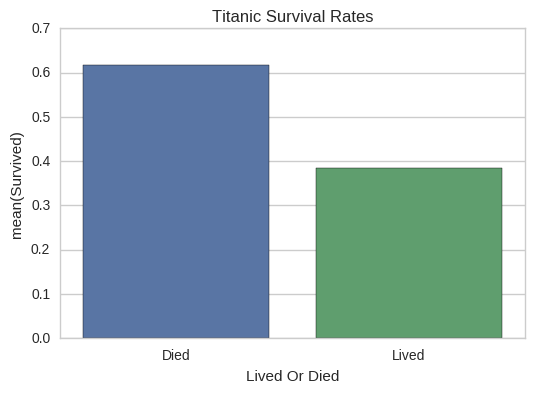

In [1260]:
axe = seaborn.barplot(x="Lived Or Died", y="Survived", data=p_frame)
title = axe.set_title("Titanic Survival Rates")

In [1261]:
print("About {:0.1f}% of the passengers survived.".format(100 * data.Survived[data.Survived == 1].count()/data.Survived.count()))

About 38.4% of the passengers survived.


## Pclass

In [1262]:
data.Pclass.unique()

array([3, 1, 2])

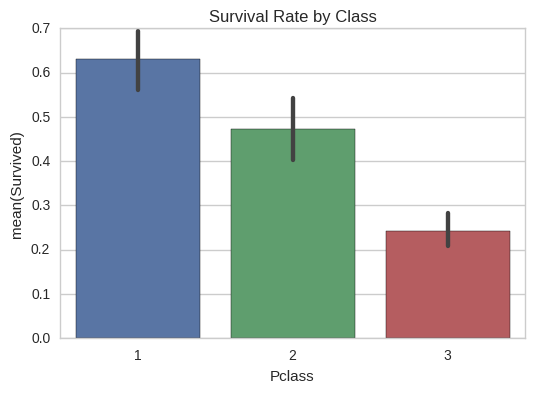

In [1263]:
axe = seaborn.barplot(x="Pclass", y="Survived", data=data)
title = axe.set_title("Survival Rate by Class")

In [1264]:
classes = sorted(data.Pclass.unique())

In [1265]:
counts = [[pclass, data.Pclass[(data.Pclass == pclass) & (data.Survived==1)].count()/data.Pclass[data.Pclass == pclass].count()] for pclass in classes]

In [1266]:
print("Fraction of each passenger class that survived.")
print(tabulate(counts, tablefmt=GRID_TYPE, headers="Class,Surival Rate".split(',')))

Fraction of each passenger class that survived.
  Class    Surival Rate
-------  --------------
      1        0.62963
      2        0.472826
      3        0.242363


It looks like the surival rate worsened as you went down in class, and if we are told that the passenger was in first class we would be correct most often if we predict that the passenger survived.

### First vs Second Class

In [1267]:
FIRST_CLASS, SECOND_CLASS, THIRD_CLASS = 0, 1, 2
counts[FIRST_CLASS][1]/counts[SECOND_CLASS][1]

1.3316304810557684

### First vs Third Class

In [1268]:
counts[FIRST_CLASS][1]/counts[THIRD_CLASS][1]

2.5978835978835981

### Second Vs Third Class

In [1269]:
counts[SECOND_CLASS][1]/counts[THIRD_CLASS][1]

1.9509042747533796

A first class passenger was more than twice as likely to survive than a third class passenger and a second class passenger was about twice as likely as a third class passenger to survive.

## Sex

In [1270]:
group_by_Sex = data.groupby("Sex")

In [1271]:
males = group_by_Sex.get_group("male")
females = group_by_Sex.get_group("female")

In [1272]:
female_description = females.describe()
male_description = males.describe()

In [1273]:
print("Males")
print(tabulate(male_description, headers=male_description.columns.tolist()))

Males
         PassengerId    Survived     Pclass       Age       SibSp       Parch      Fare
-----  -------------  ----------  ---------  --------  ----------  ----------  --------
count        577      577         577        453       577         577         577
mean         454.147    0.188908    2.38995   30.7266    0.429809    0.235702   25.5239
std          257.486    0.391775    0.81358   14.6782    1.06181     0.612294   43.1383
min            1        0           1          0.42      0           0           0
25%          222        0           2         21         0           0           7.8958
50%          464        0           3         29         0           0          10.5
75%          680        0           3         39         0           0          26.55
max          891        1           3         80         8           5         512.329


In [1274]:
print("Females")
print(tabulate(female_description, headers=female_description.columns.tolist()))

Females
         PassengerId    Survived     Pclass       Age       SibSp       Parch      Fare
-----  -------------  ----------  ---------  --------  ----------  ----------  --------
count        314      314         314        261       314         314         314
mean         431.029    0.742038    2.15924   27.9157    0.694268    0.649682   44.4798
std          256.846    0.438211    0.85729   14.1101    1.15652     1.02285    57.9977
min            2        0           1          0.75      0           0           6.75
25%          231.75     0           1         18         0           0          12.0719
50%          414.5      1           2         27         0           0          23
75%          641.25     1           3         37         1           1          55
max          889        1           3         63         8           6         512.329


Females seemed to have been more likely to be in the first and second classes than males. Most people didn't have children (Parch means parent or children).

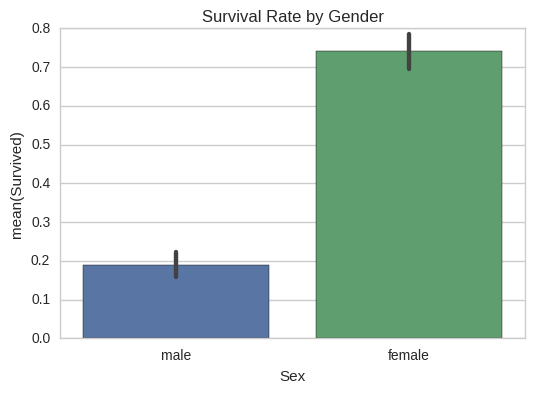

In [1275]:
axe = seaborn.barplot(x="Sex", y="Survived", data=data)
title = axe.set_title("Survival Rate by Gender")

In [1276]:
rates = [[sex, data.Sex[(data.Sex==sex) & (data.Survived==1)].count()/data.Sex[data.Sex==sex].count()] for sex in data.Sex.unique()]

In [1277]:
print(tabulate(rates, headers="Sex,Survival Rate".split(','), tablefmt=GRID_TYPE))

Sex       Survival Rate
------  ---------------
male           0.188908
female         0.742038


Females seem to have survived at a much greater rate - if we only predicted that females survived our model should be correct around 74% of the time.

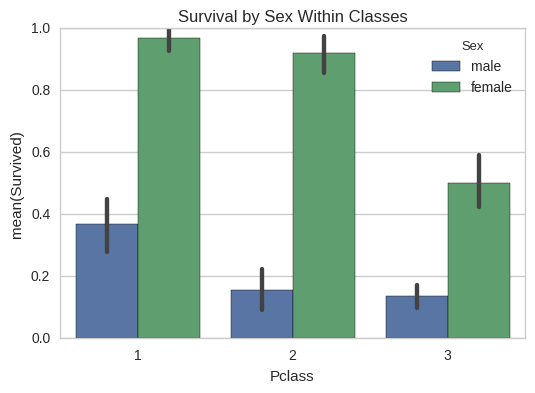

In [1278]:
axe = seaborn.barplot(x="Pclass", y="Survived", hue="Sex", data=data)
title = axe.set_title("Survival by Sex Within Classes")

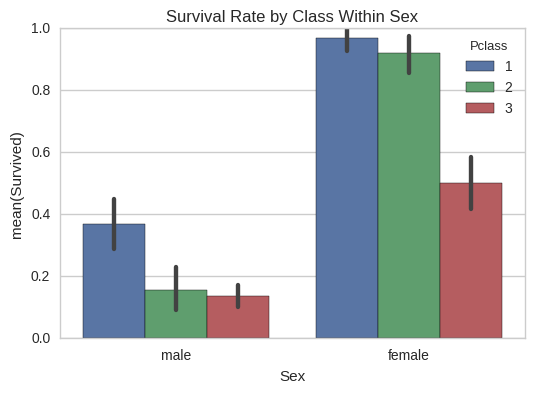

In [1279]:
axe = seaborn.barplot(x="Sex", y="Survived", hue="Pclass", data=data)
title = axe.set_title("Survival Rate by Class Within Sex")

It looks like being female always was an advantage, but first and second class females were the most likely to survive, and being in second class was a bigger advantage for females than it was for males.

In [1280]:
def class_rates_by_sex(data, sex):
    data = data[data.Sex==sex]
    classes = sorted(data.Pclass.unique())
    counts = [[pclass, data.Pclass[(data.Pclass == pclass) & (data.Survived==1)].count()/data.Pclass[data.Pclass == pclass].count()] for pclass in classes]
    print(tabulate(counts, tablefmt="grid", headers="Class,Surival Rate".split(',')))

In [1281]:
class_rates_by_sex(data, "female")

+---------+----------------+
|   Class |   Surival Rate |
+=========+================+
|       1 |       0.968085 |
+---------+----------------+
|       2 |       0.921053 |
+---------+----------------+
|       3 |       0.5      |
+---------+----------------+


In [1282]:
class_rates_by_sex(data, "male")

+---------+----------------+
|   Class |   Surival Rate |
+=========+================+
|       1 |       0.368852 |
+---------+----------------+
|       2 |       0.157407 |
+---------+----------------+
|       3 |       0.135447 |
+---------+----------------+


So far it looks like it would be a safe bet to assume that a woman in first or second class survived, that a man did not survive and that a woman in third class had an equal chance of surviving or not surviving.

## Age

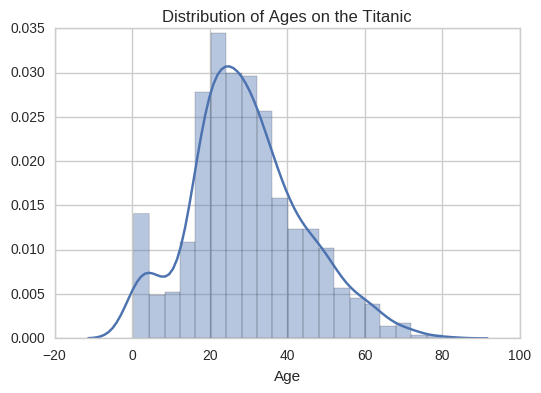

In [1283]:
axe = seaborn.distplot(data.Age.dropna())
title = axe.set_title("Distribution of Ages on the Titanic")

The age data seems to be right skewed with an odd spike at the start.

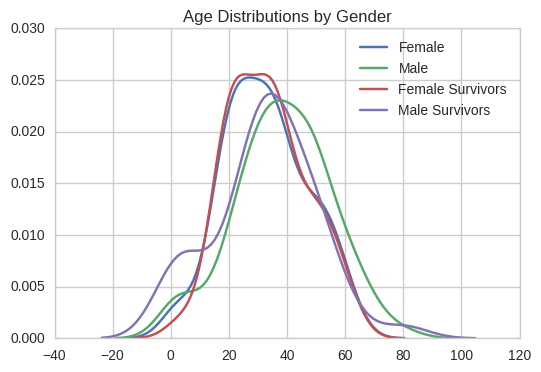

In [1284]:
females = data[data.Sex=="female"].dropna()
males = data[data.Sex=="male"].dropna()
female_survivors = females[females.Survived==1]
male_survivors = males[males.Survived==1]
f_median = female_survivors.median()
axe = seaborn.kdeplot(females.Age, label="Female")
axe = seaborn.kdeplot(males.Age, label="Male")
axe = seaborn.kdeplot(female_survivors.Age, label="Female Survivors")
axe = seaborn.kdeplot(male_survivors.Age, label="Male Survivors")
title = axe.set_title("Age Distributions by Gender")

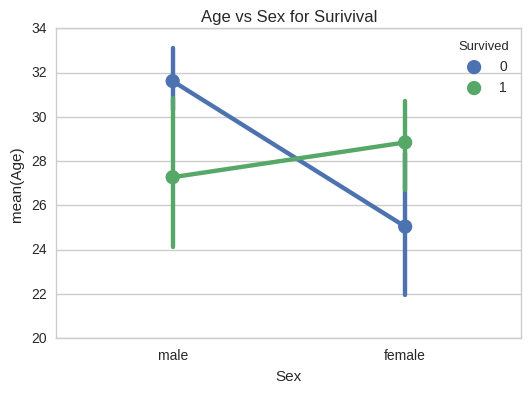

In [1285]:
axe = seaborn.pointplot(x="Sex", y="Age", hue="Survived", data=data)
title = axe.set_title("Age vs Sex for Surivival")

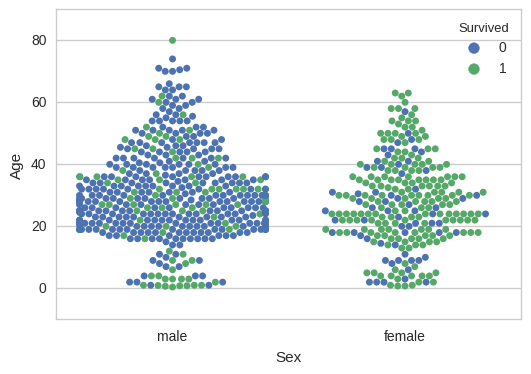

In [1286]:
axe = seaborn.swarmplot(x="Sex", y="Age", hue="Survived", data=data)

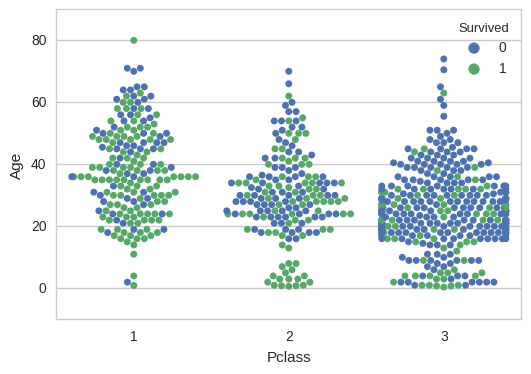

In [1287]:
axe = seaborn.swarmplot(x="Pclass", y="Age", hue="Survived", data=data)

The males seem to have been older, on average, although the male survivors were younger on average than females.

In [1288]:
age_description = data.Age.describe()

In [1289]:
print(tabulate(pandas.DataFrame({"Age": age_description}), headers="Statistic Value".split(), tablefmt=GRID_TYPE))

Statistic       Value
-----------  --------
count        714
mean          29.6991
std           14.5265
min            0.42
25%           20.125
50%           28
75%           38
max           80


The median age on the titanic was 28, and 75% percent of the passengers were 38 or younger.

In [1290]:
bins = list(range(0, 85, 5))

In [1291]:
age_groups = pandas.cut(data.Age, bins)
data["AgeGroups"] = age_groups

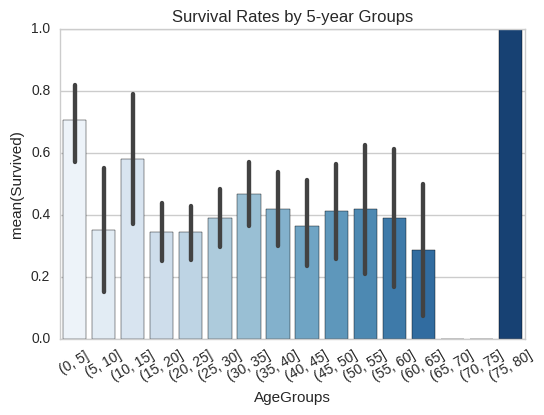

In [1292]:
axe = seaborn.barplot(x="AgeGroups", y="Survived", data=data, palette="Blues")
ticks = axe.set_xticklabels(axe.xaxis.get_majorticklabels(), rotation=30)
title = axe.set_title("Survival Rates by 5-year Groups")

It looks like those younger than 15 and older than 75 were most likely to surive, with another peak around 30-35.

In [1293]:
data.Age[data.Age > 75].count()

1

In [1294]:
data.Age[data.Age < 15].count()

78

There was only one person over 75 so the oldest age is probably not significant.

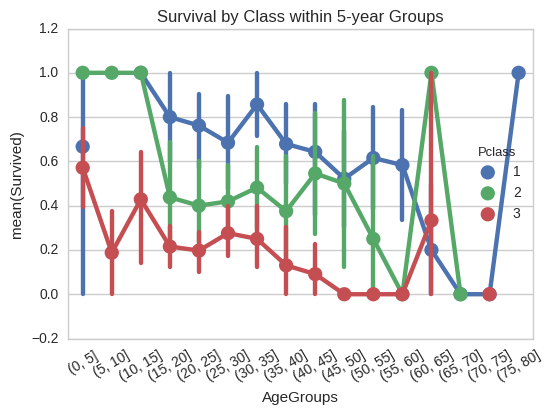

In [1295]:
axe = seaborn.pointplot(x="AgeGroups", y="Survived", hue="Pclass", data=data, palette="deep")
ticks = axe.set_xticklabels(axe.xaxis.get_majorticklabels(), rotation=30)
title = axe.set_title("Survival by Class within 5-year Groups")

This plot seems to say that first and second class passengers 15 and younger had a high survival rate (regardless of gender), as did some classes of older passengers. The lack of pattern for older passengers likely reflects the fact that there were fewer of them. The slight peak around 35 seems to be true of first class passengers, while the second class passengers' survival rate peaked around 45 and the third class passenger's surival rate for adults peaked slightly younger around 25-30. There's an odd bump at 60-65 for second class passengers (and to some degree third-class passengers.

In [1296]:
print(tabulate(data[(data.Age > 60) & ((data.Pclass==2) | (data.Pclass==3))]["AgeGroups Survived Pclass Sex".split()], headers=["ID","Age Group", "Survived", "Class", "Sex"], tablefmt="psql"))

+------+-------------+------------+---------+--------+
|   ID | Age Group   |   Survived |   Class | Sex    |
|------+-------------+------------+---------+--------|
|   33 | (65, 70]    |          0 |       2 | male   |
|  116 | (70, 75]    |          0 |       3 | male   |
|  280 | (60, 65]    |          0 |       3 | male   |
|  326 | (60, 65]    |          0 |       3 | male   |
|  483 | (60, 65]    |          1 |       3 | female |
|  570 | (60, 65]    |          1 |       2 | male   |
|  672 | (65, 70]    |          0 |       2 | male   |
|  851 | (70, 75]    |          0 |       3 | male   |
+------+-------------+------------+---------+--------+


In [1297]:
print(tabulate(data[(data.Age > 60) & (data.Pclass == 1)]["AgeGroups Age Survived Pclass Sex".split()], headers=["ID","Age Group", "Survived", "Class", "Sex"], tablefmt="psql"))

+-----+----------+-------------+------------+---------+--------+
|     | ID       |   Age Group |   Survived |   Class | Sex    |
|-----+----------+-------------+------------+---------+--------|
|  54 | (60, 65] |          65 |          0 |       1 | male   |
|  96 | (70, 75] |          71 |          0 |       1 | male   |
| 170 | (60, 65] |          61 |          0 |       1 | male   |
| 252 | (60, 65] |          62 |          0 |       1 | male   |
| 275 | (60, 65] |          63 |          1 |       1 | female |
| 438 | (60, 65] |          64 |          0 |       1 | male   |
| 456 | (60, 65] |          65 |          0 |       1 | male   |
| 493 | (70, 75] |          71 |          0 |       1 | male   |
| 545 | (60, 65] |          64 |          0 |       1 | male   |
| 555 | (60, 65] |          62 |          0 |       1 | male   |
| 625 | (60, 65] |          61 |          0 |       1 | male   |
| 630 | (75, 80] |          80 |          1 |       1 | male   |
| 745 | (65, 70] |       

Of the 60-65 group only one was in the second class and he survived, accounting for the anomalous 100% spike for that class and age group. There was also only one person 80 or older and he survived, which accounts for the 100% survival rate for first class passengers eighty or older.

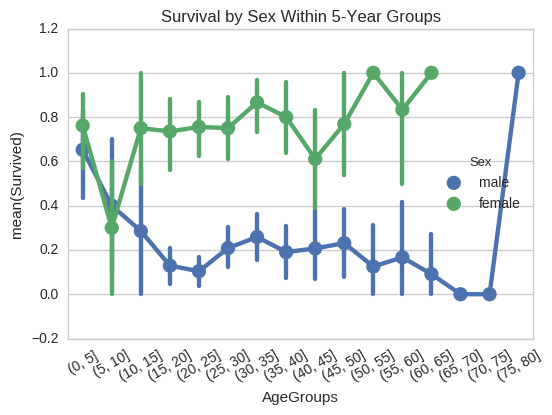

In [1298]:
axe = seaborn.pointplot(x="AgeGroups", y="Survived", hue="Sex", data=data, palette="deep")
ticks = axe.set_xticklabels(axe.xaxis.get_majorticklabels(), rotation=30)
title = axe.set_title("Survival by Sex Within 5-Year Groups")

In [1299]:
anomalous = data[(data.Age > 5) & (data.Age <= 10)]
print(anomalous.Age.count())

20


In [1300]:
print(anomalous.Age[anomalous.Sex=="female"].count())

10


Except for the anomalous range of 5 to 10 year olds, it appears that females survived at a higher rate no matter their age.

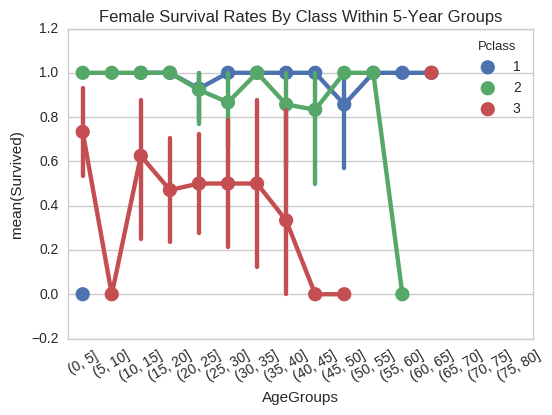

In [1301]:
females = data[data.Sex=="female"]
axe = seaborn.pointplot(x="AgeGroups", y="Survived", hue="Pclass", data=females, palette="deep")
ticks = axe.set_xticklabels(axe.xaxis.get_majorticklabels(), rotation=30)
title = axe.set_title("Female Survival Rates By Class Within 5-Year Groups")

The class difference in female survival rates seems to have had an overwhelming effect over age.

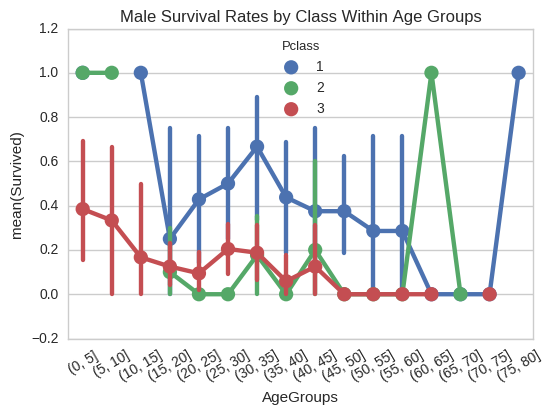

In [1302]:
males = data[data.Sex=="male"]
axe = seaborn.pointplot(x="AgeGroups", y="Survived", hue="Pclass", data=males)
ticks = axe.set_xticklabels(axe.xaxis.get_majorticklabels(), rotation=30)
title = axe.set_title("Male Survival Rates by Class Within Age Groups")

With males the effect seems to be murkier.The first class passengers generally did better, and the second-class children enjoyed an advantage, but the adult male second-class passengers seem to have done as poorly, or worse than, the third class passengers for the most part. There definitely seemed to be an advantage for first-class males who were either very young, very old, or around 35.

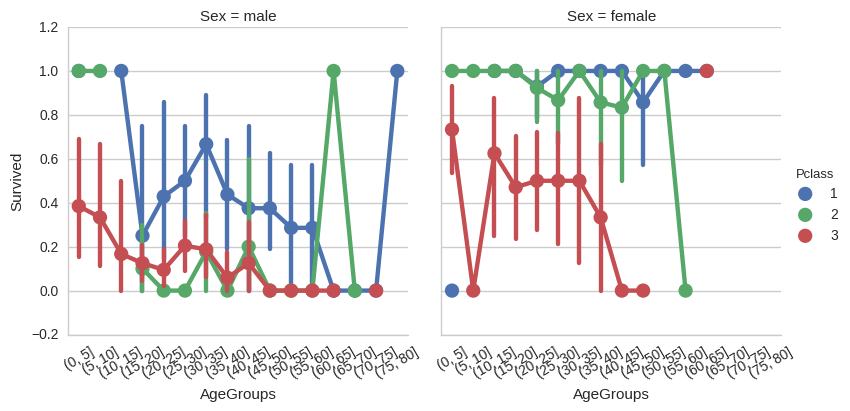

In [1303]:
axe = seaborn.factorplot(x="AgeGroups", y="Survived", hue="Pclass", col="Sex", data=data)
ticks = axe.set_xticklabels(rotation=30)
# title = axe.set(title="Survival Rates by Class Within Age Groups")

## SibSp

SibSp is the count of siblings and spouses you had on the ship, which seems like an odd combination.

In [1304]:
data.SibSp.unique()

array([1, 0, 3, 4, 2, 5, 8])

What? 8?

In [1305]:
data.Pclass[data.SibSp == 8]

159    3
180    3
201    3
324    3
792    3
846    3
863    3
Name: Pclass, dtype: int64

Ach, the filthy unwashed. They breed like flies.

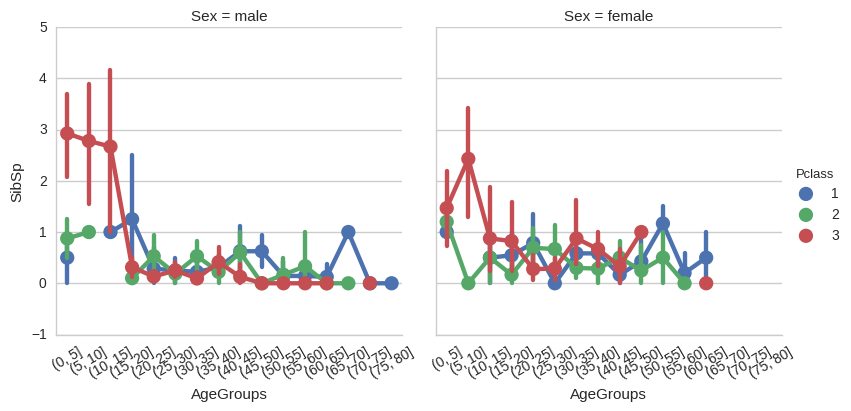

In [1306]:
axe = seaborn.factorplot(x="AgeGroups", y="SibSp", hue="Pclass", col="Sex", data=data)
ticks = axe.set_xticklabels(rotation=30)


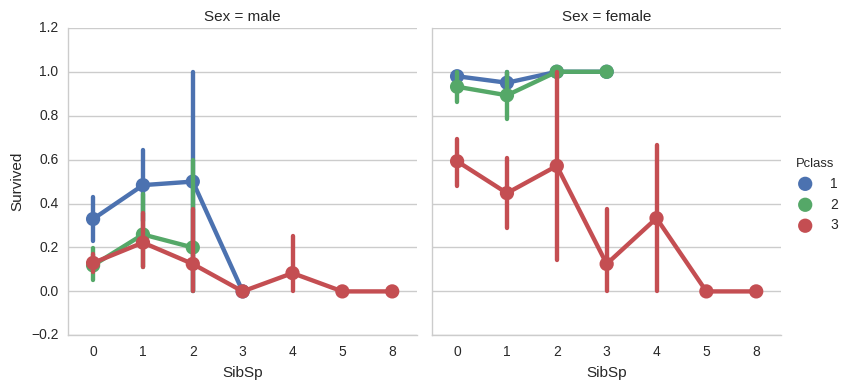

In [1307]:
axe = seaborn.factorplot(x="SibSp", y="Survived", hue="Pclass", col="Sex", data=data)


This seems to indicate that having 3 or more siblings or spouses decreased the likelihood of a third-class passenger surviving. For some reason males having no siblings or spouses were more likely than those with one (or two if they were in first or second class), perhaps because single men were expected to go down with the ship.

## Parch

``Parch`` is the number of parents and children a passenger had on board.

In [1308]:
print(data.Parch.unique())

[0 1 2 5 3 4 6]


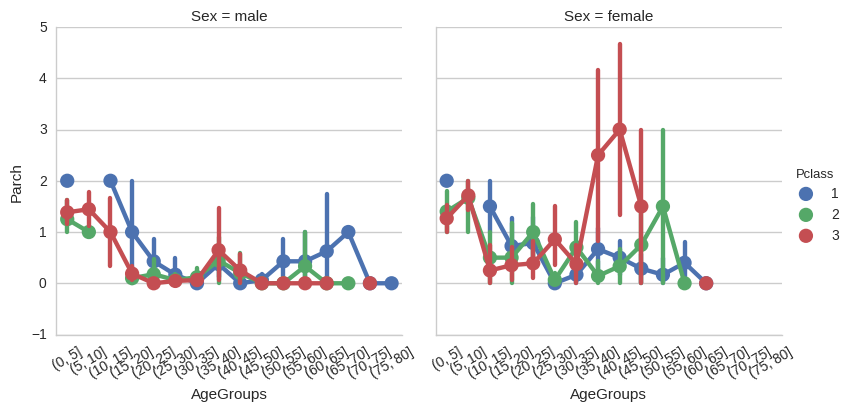

In [1309]:
axe = seaborn.factorplot(x="AgeGroups", y="Parch", hue="Pclass", col="Sex", data=data)
ticks = axe.set_xticklabels(rotation=30)


The slightly higher spike on the left hand side would seem to indicate that these are children travelling with their parents while the noticeable around 30-45 for third-class women indicates the count of their children (although they might also have been more likely to travel with both parents and children, it's hard to say with these combined variables).

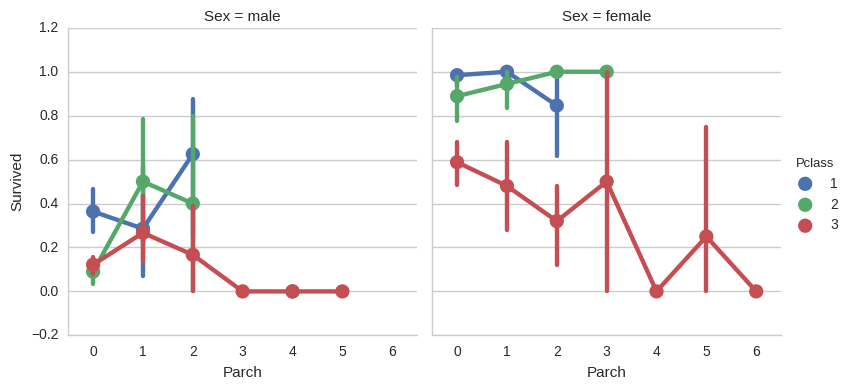

In [1310]:
axe = seaborn.factorplot(x="Parch", y="Survived", hue="Pclass", col="Sex", data=data)


## Fares

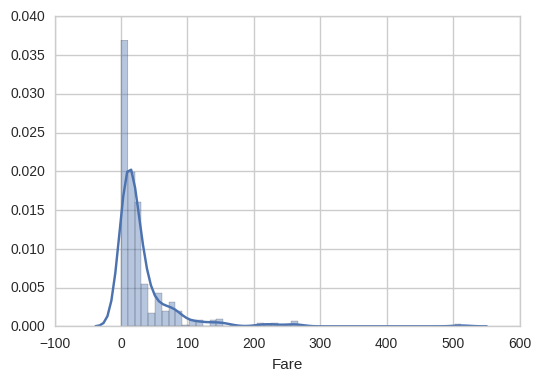

In [1311]:
axe = seaborn.distplot(data.Fare)

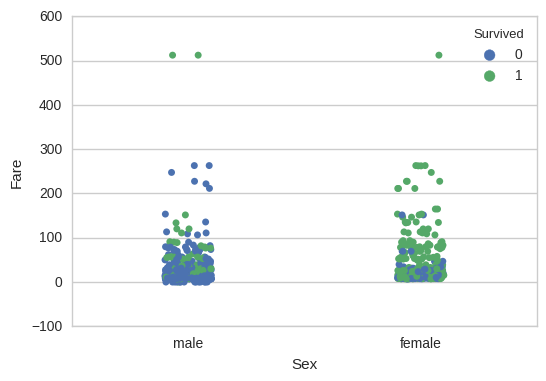

In [1312]:
axe = seaborn.stripplot(x="Sex", y="Fare", hue="Survived", data=data, jitter=True)

In [1313]:
data["CheapFare"] = data[data.Fare < 100].Fare

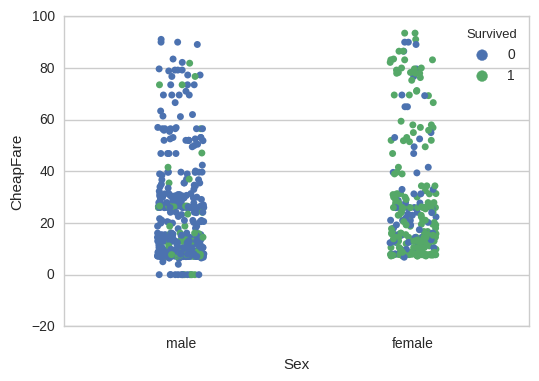

In [1314]:
axe = seaborn.stripplot(x="Sex", y="CheapFare", hue="Survived", data=data, jitter=True)

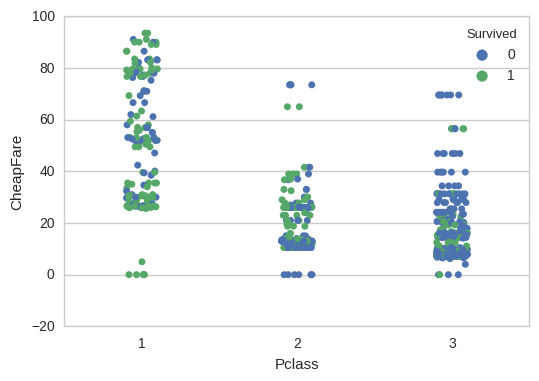

In [1315]:
axe = seaborn.stripplot(x="Pclass", y="CheapFare", hue="Survived", data=data, jitter=True)

Surprisingly, there doesn't seem to be a one-to-one mapping between price and class.

## Names

In [1316]:
children = data[(data.Age <= 15) &  (data.Sex=="male")]
children.Name.head(20)

7                       Palsson, Master. Gosta Leonard
16                                Rice, Master. Eugene
50                          Panula, Master. Juha Niilo
59                  Goodwin, Master. William Frederick
63                               Skoog, Master. Harald
78                       Caldwell, Master. Alden Gates
125                       Nicola-Yarred, Master. Elias
164                       Panula, Master. Eino Viljami
165    Goldsmith, Master. Frank John William "Frankie"
171                               Rice, Master. Arthur
182              Asplund, Master. Clarence Gustaf Hugo
183                          Becker, Master. Richard F
193                         Navratil, Master. Michel M
261                  Asplund, Master. Edvin Rojj Felix
278                                 Rice, Master. Eric
305                     Allison, Master. Hudson Trevor
340                     Navratil, Master. Edmond Roger
348             Coutts, Master. William Loch "William"
352       

In [1317]:
def is_master(row):
    return "Master" in row.Name

boys = data[data.apply(is_master, axis=1)]
boys.Age.describe()

count    36.000000
mean      4.574167
std       3.619872
min       0.420000
25%       1.000000
50%       3.500000
75%       8.000000
max      12.000000
Name: Age, dtype: float64

In [1318]:
boys.Age.median()

3.5

# Cleaning the data

## Re-mapping gender

Besides needing to convert the Sexes to numbers, we have to make sure that we do the same transformation on the test set so it will be able to work the same model.

In [1319]:
gender_map = {"female": 0, "male": 1}
data["Gender"] = data.Sex.map(gender_map)
test_data["Gender"] = test_data.Sex.map(gender_map)

In [1320]:
assert data.Gender[data.Gender==1].count() == data.Sex[data.Sex=="male"].count()

## Filling in missing ages

First, males with "Master" in their name are classified as children.

In [1321]:
data["AgeFill"] = data.Age.copy()
test_data["AgeFill"] = test_data.Age.copy()

In [1322]:
len(data.AgeFill[data.AgeFill.isnull()])

177

In [1323]:
data.AgeFill[(data.apply(is_master, axis=1)) & (data.AgeFill.isnull())] = boys.Age.median() 

In [1324]:
len(data.AgeFill[data.AgeFill.isnull()])

173

Since gender and class seem to be important, the median age for each gender/class combination will be used to fill in missing values.

In [1325]:
data.Age.median()

28.0

In [1326]:
groups = data.groupby(["Gender", "Pclass"])
groups.median().Age

Gender  Pclass
0       1         35.0
        2         28.0
        3         21.5
1       1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [1327]:
# this turns off the warning that you're assining a value to a copy
pandas.set_option("chained_assignment", None)

In [1328]:
medians = groups.median().Age

In [1329]:
datasets = [data, test_data]
for gender in (0, 1):
    for pclass in (1, 2, 3):
        for dataset in datasets:
            dataset.AgeFill[(dataset["Gender"]==gender) & (dataset["Pclass"]==pclass) & (dataset["Age"].isnull())] = medians[gender][pclass] 


In [1330]:
filled_groups = data.groupby(["Gender", "Pclass"] )
filled_medians = filled_groups.median().AgeFill

In [1331]:
medians[0][1]

35.0

In [1332]:
filled_medians

Gender  Pclass
0       1         35.0
        2         28.0
        3         21.5
1       1         40.0
        2         30.0
        3         25.0
Name: AgeFill, dtype: float64

In [1333]:
# make sure we didn't do something wrong and change the median
for gender in (0, 1):
    for pclass in (1, 2, 3):
        assert medians[gender][pclass] == data.AgeFill[(data.Gender==gender) &
                                                       (data.Pclass==pclass)].median()

In [1334]:
assert not data.AgeFill.hasnans
assert not test_data.AgeFill.hasnans

In [1335]:
data[["Age", "AgeFill"]][(data.Age.isnull())].head()

    Age  AgeFill
5   NaN     25.0
17  NaN     30.0
19  NaN     21.5
26  NaN     25.0
28  NaN     21.5

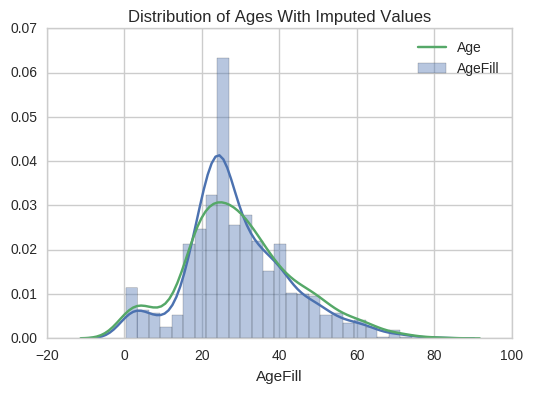

In [1336]:
axe = seaborn.distplot(data.AgeFill, label="AgeFill")
axe = seaborn.kdeplot(data.Age.dropna(), label="Age")
title = axe.set_title("Distribution of Ages With Imputed Values")

The shape looks roughly the same but is much steeper in the middle than it was without the imputed data.

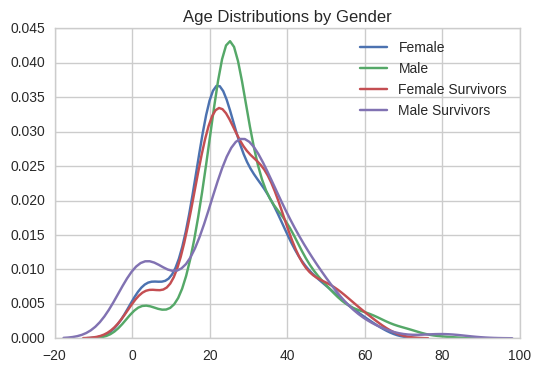

In [1337]:
females = data[data.Sex=="female"]
males = data[data.Sex=="male"]
female_survivors = females[females.Survived==1]
male_survivors = males[males.Survived==1]

axe = seaborn.kdeplot(females.AgeFill, label="Female")
axe = seaborn.kdeplot(males.AgeFill, label="Male")
axe = seaborn.kdeplot(female_survivors.AgeFill, label="Female Survivors")
axe = seaborn.kdeplot(male_survivors.AgeFill, label="Male Survivors")
title = axe.set_title("Age Distributions by Gender")

Infilling the values seems to have skewed the ages younger. Since we used the medians the actual centers should be the same, so the data was likely skewed right.

In [1338]:
data["AgeFillGroups"] = pandas.cut(data.AgeFill, bins)

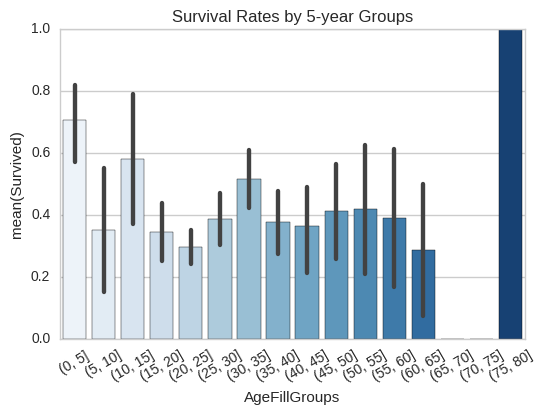

In [1339]:
axe = seaborn.barplot(x="AgeFillGroups", y="Survived", data=data, palette="Blues")
ticks = axe.set_xticklabels(axe.xaxis.get_majorticklabels(), rotation=30)
title = axe.set_title("Survival Rates by 5-year Groups")

This looks pretty much the same as the un-filled groups.

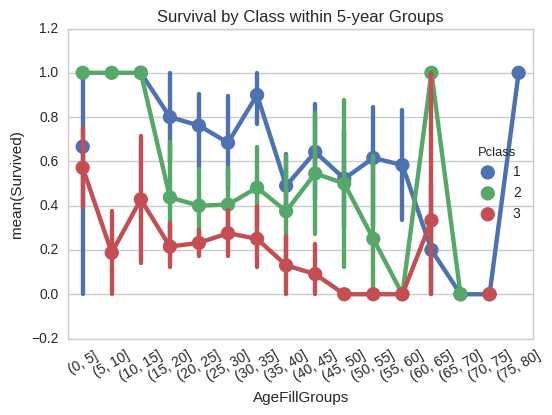

In [1340]:
axe = seaborn.pointplot(x="AgeFillGroups", y="Survived", hue="Pclass", data=data, palette="deep")
ticks = axe.set_xticklabels(axe.xaxis.get_majorticklabels(), rotation=30)
title = axe.set_title("Survival by Class within 5-year Groups")


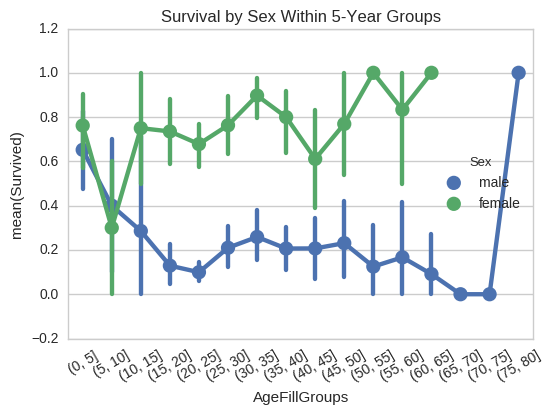

In [1341]:
axe = seaborn.pointplot(x="AgeFillGroups", y="Survived", hue="Sex", data=data, palette="deep")
ticks = axe.set_xticklabels(axe.xaxis.get_majorticklabels(), rotation=30)
title = axe.set_title("Survival by Sex Within 5-Year Groups")

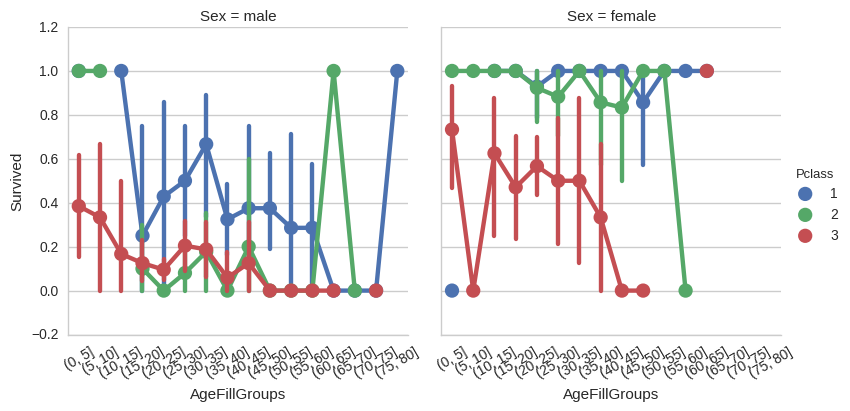

In [1342]:
axe = seaborn.factorplot(x="AgeFillGroups", y="Survived", hue="Pclass", col="Sex", data=data)
ticks = axe.set_xticklabels(rotation=30)

## Embarked

Strings have to be converted to numbers for SKlearn to use them. In addition this variable has some ``nan`` values that need to be cleaned up.

In [1343]:
embarked_group = data.groupby(["Gender", "Pclass", "Embarked"])
embarked_group.Embarked.size()

Gender  Pclass  Embarked
0       1       C            43
                Q             1
                S            48
        2       C             7
                Q             2
                S            67
        3       C            23
                Q            33
                S            88
1       1       C            42
                Q             1
                S            79
        2       C            10
                Q             1
                S            97
        3       C            43
                Q            39
                S           265
dtype: int64

In [1344]:
data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

I don't have a good scheme here so I'll re-code them:
0:S
1:C
2:Q

And infill the missing with "S".

In [1345]:
city_map = dict(zip("S C Q".split(), (0, 1, 2)))

In [1346]:
for dataset in datasets:
    dataset["EmbarkedCode"] = dataset.Embarked.map(city_map)
    dataset.EmbarkedCode[dataset.EmbarkedCode.isnull()] = 0
    data.EmbarkedCode = data.EmbarkedCode.astype(int)

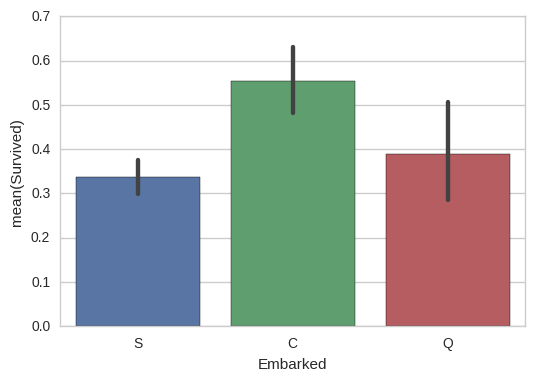

In [1347]:
axe = seaborn.barplot(x="Embarked", y="Survived", data=data)

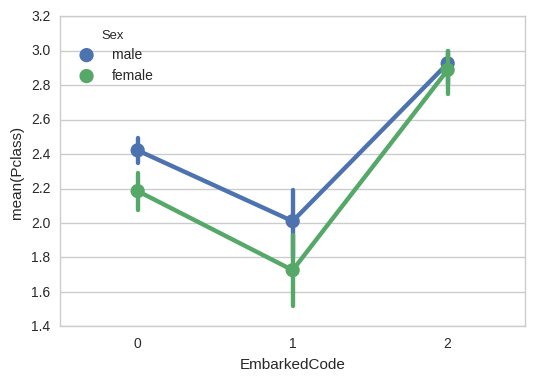

In [1348]:
axe = seaborn.pointplot(x="EmbarkedCode", y="Pclass", hue="Sex", data=data)

It looks like you were more likely to survive if you embarked at Cherbourg, but that was also where the first class passengers seem to have gotten on board, so it might be related to that.

In [1349]:
for column in data.columns:
    if data[column].hasnans:
        print(column)

Age
Cabin
Embarked
AgeGroups
CheapFare


In [1350]:
for column in data.columns:
    if data[column].hasnans:
        print(column)

Age
Cabin
Embarked
AgeGroups
CheapFare


In [1351]:
for column in test_data.columns:
    if test_data[column].hasnans:
        print(column)

Age
Fare
Cabin


## Fares

In [1352]:
missing_fare = test_data[test_data.Fare.isnull()]
missing_fare

     PassengerId  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

     Fare Cabin Embarked  Gender  AgeFill  EmbarkedCode  
152   NaN   NaN        S       1     60.5             0  

Since there's only one missing value, I'll use the median again.

In [1353]:
test_data[test_data.Fare.isnull()] = test_data[(test_data.Pclass==3) & (test_data.Gender==1) & (test_data.EmbarkedCode==0)].Fare.median()

In [1354]:
for column in test_data.columns:
    if test_data[column].hasnans:
        print(column)

Age
Cabin


# Feature Engineering

## Family Size

Adding ``Parch`` and ``SibSp`` gives a marker for how many members of a passenger's nuclear family were on board.

In [1355]:
for dataset in datasets:
    dataset["FamilySize"] = dataset.Parch + dataset.SibSp

In [1356]:
data.FamilySize.describe()

count    891.000000
mean       0.904602
std        1.613459
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: FamilySize, dtype: float64

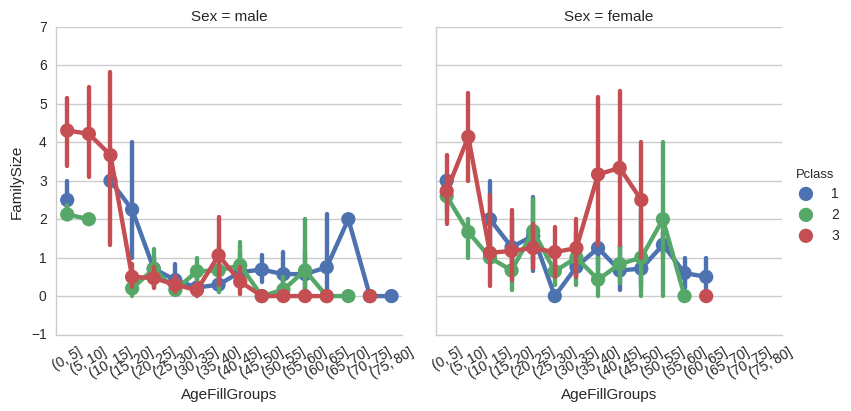

In [1357]:
axe = seaborn.factorplot(x="AgeFillGroups", y="FamilySize", hue="Pclass", col="Sex", data=data)
ticks = axe.set_xticklabels(rotation=30)


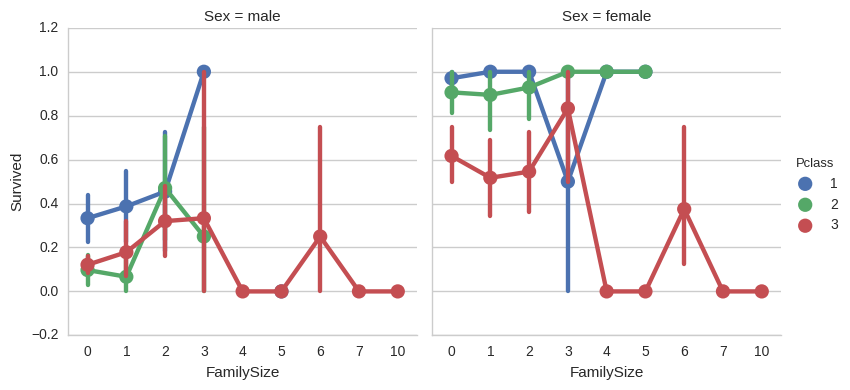

In [1358]:
axe = seaborn.factorplot(x="FamilySize", y="Survived", hue="Pclass", col="Sex", data=data)

As with ``SibSp`` and ``Parch``, having more than 3 family members seemed to hurt the third class.

## Age and Class

The idea here is that being older made you less likely to survive, the lower your class, so you create a combined :math:`Age \times Class` column that will exagerate the age as the class goes lower (so the class value goes higher).

In [1359]:
for dataset in datasets:
    dataset["AgeXClass"] = dataset.AgeFill * dataset.Pclass

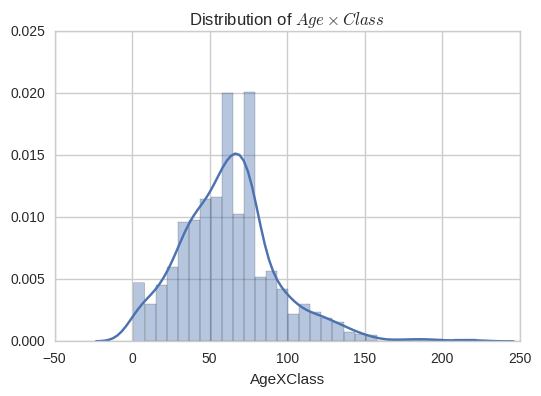

In [1360]:
axe = seaborn.distplot(data.AgeXClass)
title = axe.set_title(r"Distribution of $Age \times Class$")

In [1361]:
data.AgeXClass.describe()

count    891.000000
mean      62.614860
std       31.362024
min        0.920000
25%       40.000000
50%       63.000000
75%       75.000000
max      222.000000
Name: AgeXClass, dtype: float64

In [1362]:
data["AgeXClassBins"] = pandas.cut(data.AgeXClass, list(range(0, 230, 10)))


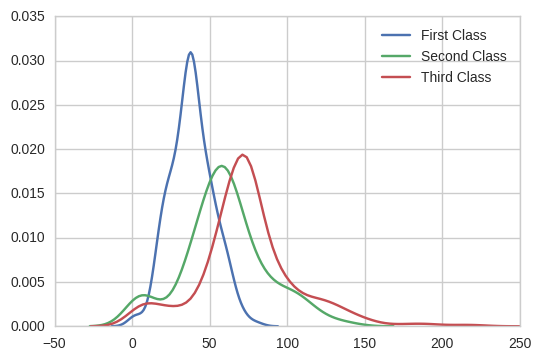

In [1363]:
axe = seaborn.kdeplot(data[data.Pclass==1].AgeXClass, label="First Class")
axe = seaborn.kdeplot(data[data.Pclass==2].AgeXClass, label="Second Class")
axe = seaborn.kdeplot(data[data.Pclass==3].AgeXClass, label="Third Class")

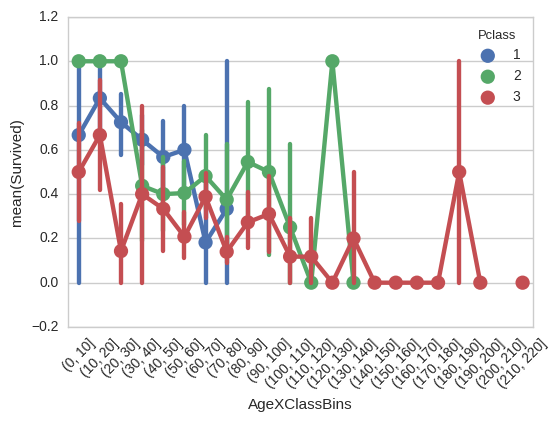

In [1364]:
axe = seaborn.pointplot(x="AgeXClassBins", y="Survived", hue="Pclass", data=data)
ticks = axe.set_xticklabels(axe.xaxis.get_majorticklabels(), rotation=45)

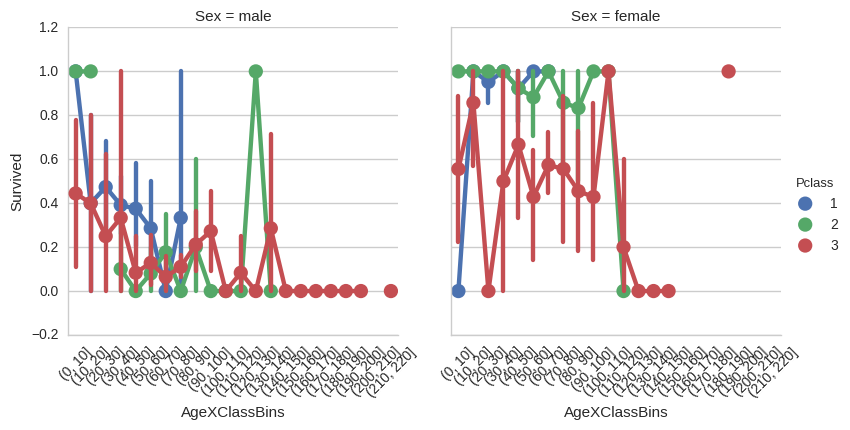

In [1365]:
axe = seaborn.factorplot(x="AgeXClassBins", y="Survived", hue="Pclass", col="Sex", data=data)
ticks = axe.set_xticklabels(rotation=45)

The idea sounds okay, but it's not obvious from looking at the plots that you've really gained anything.

# Prepare For SKlearn

Before SKlearn can use our data, we have to drop the non-numeric columns and convert the DataFrame to a numpy array.

In [1366]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'AgeGroups',
       'CheapFare', 'Gender', 'AgeFill', 'AgeFillGroups', 'EmbarkedCode',
       'FamilySize', 'AgeXClass', 'AgeXClassBins'],
      dtype='object')

In [1367]:
non_numeric = [column for column in data.columns if data[column].dtype not in NUMERIC_TYPES]
print(to_drop)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'AgeGroups', 'AgeFillGroups', 'AgeXClassBins', 'Age', 'Cabin', 'Embarked', 'AgeGroups', 'CheapFare', 'AgeXClassBins']


In [1368]:
has_nans = [column for column in data.columns if data[column].hasnans]
print(has_nans)

['Age', 'Cabin', 'Embarked', 'AgeGroups', 'CheapFare', 'AgeXClassBins']


In [1369]:
to_drop = non_numeric + has_nans

In [1370]:
data = data.drop(to_drop, axis=1)
test_data = test_data.drop(NON_NUMERIC + HAS_NANS, axis=1)

In [1371]:
data.describe()

       PassengerId    Survived      Pclass       SibSp       Parch  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642    0.523008    0.381594   
std     257.353842    0.486592    0.836071    1.102743    0.806057   
min       1.000000    0.000000    1.000000    0.000000    0.000000   
25%     223.500000    0.000000    2.000000    0.000000    0.000000   
50%     446.000000    0.000000    3.000000    0.000000    0.000000   
75%     668.500000    1.000000    3.000000    1.000000    0.000000   
max     891.000000    1.000000    3.000000    8.000000    6.000000   

             Fare      Gender     AgeFill  EmbarkedCode  FamilySize  \
count  891.000000  891.000000  891.000000    891.000000  891.000000   
mean    32.204208    0.647587   29.112424      0.361392    0.904602   
std     49.693429    0.477990   13.304424      0.635673    1.613459   
min      0.000000    0.000000    0.420000      0.000000    0.000000   
25%      7.910

Since the PassengerId doesn't seem useful I'm going to get rid of it. This will also make the "Survived" column the first so it will be easier to get it out of the data for sklearn.

In [1372]:
data = data.drop(["PassengerId"], axis=1)

In [1373]:
test_data = test_data.drop(["PassengerId"], axis=1)

In [1374]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived        891 non-null int64
Pclass          891 non-null int64
SibSp           891 non-null int64
Parch           891 non-null int64
Fare            891 non-null float64
Gender          891 non-null int64
AgeFill         891 non-null float64
EmbarkedCode    891 non-null int64
FamilySize      891 non-null int64
AgeXClass       891 non-null float64
dtypes: float64(3), int64(7)
memory usage: 69.7 KB


Although I said I was going to convert it to an array I'm actually just going to save the data and load it in another notebook.

In [1375]:
data.to_csv("training_cleaned.csv", index=False)
test_data.to_csv("testing_cleaned.csv", index=False)

In [1376]:
!head training_cleaned.csv

Survived,Pclass,SibSp,Parch,Fare,Gender,AgeFill,EmbarkedCode,FamilySize,AgeXClass
0,3,1,0,7.25,1,22.0,0,1,66.0
1,1,1,0,71.2833,0,38.0,1,1,38.0
1,3,0,0,7.925,0,26.0,0,0,78.0
1,1,1,0,53.1,0,35.0,0,1,35.0
0,3,0,0,8.05,1,35.0,0,0,105.0
0,3,0,0,8.4583,1,25.0,2,0,75.0
0,1,0,0,51.8625,1,54.0,0,0,54.0
0,3,3,1,21.075,1,2.0,0,4,6.0
1,3,0,2,11.1333,0,27.0,0,2,81.0


In [1377]:
!head testing_cleaned.csv

Pclass,SibSp,Parch,Fare,Gender,AgeFill,EmbarkedCode,FamilySize,AgeXClass
3.0,0.0,0.0,7.8292,1.0,34.5,2.0,0.0,103.5
3.0,1.0,0.0,7.0,0.0,47.0,0.0,1.0,141.0
2.0,0.0,0.0,9.6875,1.0,62.0,2.0,0.0,124.0
3.0,0.0,0.0,8.6625,1.0,27.0,0.0,0.0,81.0
3.0,1.0,1.0,12.2875,0.0,22.0,0.0,2.0,66.0
3.0,0.0,0.0,9.225,1.0,14.0,0.0,0.0,42.0
3.0,0.0,0.0,7.6292,0.0,30.0,2.0,0.0,90.0
2.0,1.0,1.0,29.0,1.0,26.0,0.0,2.0,52.0
3.0,0.0,0.0,7.2292,0.0,18.0,1.0,0.0,54.0


In [1378]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
Pclass          418 non-null float64
SibSp           418 non-null float64
Parch           418 non-null float64
Fare            418 non-null float64
Gender          418 non-null float64
AgeFill         418 non-null float64
EmbarkedCode    418 non-null float64
FamilySize      418 non-null float64
AgeXClass       418 non-null float64
dtypes: float64(9)
memory usage: 29.5 KB
